In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# Install and load all libraries

In [2]:
from utils import *

In [24]:
tools_list = ['permanent cautery hook/spatula',
              'tip-up fenestrated grasper',
              'stapler',
              'suction irrigator',
              'grasping retractor',
              'monopolar curved scissors',
              'clip applier',
              'vessel sealer',
              'nan',
              'bipolar forceps',
              'cadiere forceps',
              'bipolar dissector',
              'force bipolar',
              'needle driver',
              'prograsp forceps']

dls = DataBlock(blocks=(ImageBlock,CategoryBlock(vocab=tools_list)),
                get_x=ColReader('image_id'),
                get_y=ColReader('y1_label'),
                splitter=splitter,
                item_tfms=Resize((180,320), ResizeMethod.Squish),
                batch_tfms=[*aug_transforms(size=(180,320), min_scale=1),
                           Normalize.from_stats(*imagenet_stats)]).dataloaders(images_df)
                

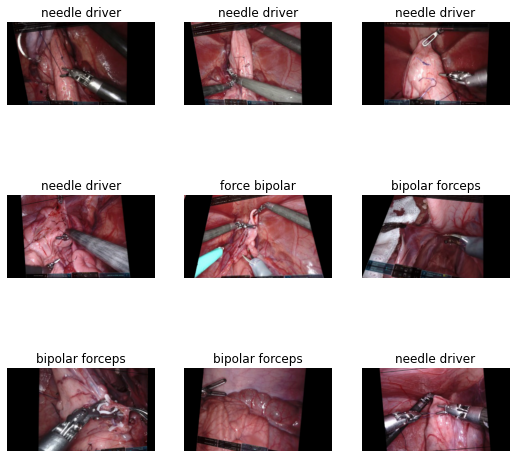

In [25]:
dls.show_batch()

# Creating differe dataloaders

In [26]:
learn = vision_learner(dls,'convnext_small_in22k',metrics=error_rate).to_fp16()

In [27]:
learn.fine_tune(2, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.942472,0.731672,0.227006,01:49


epoch,train_loss,valid_loss,error_rate,time
0,0.808830,0.681956,0.211001,02:26
1,0.781871,0.652615,0.205328,02:26


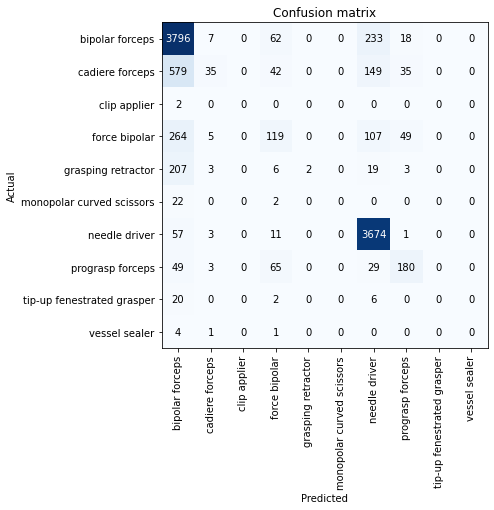

In [23]:
interp.plot_confusion_matrix(figsize=(7,7))

In [29]:
x, = first(dls.test_dl(['data/train_images_tiny/clip_000003/00000.jpg'])); 
x.shape

torch.Size([1, 3, 180, 320])

In [30]:
cls,idx,prob=learn.predict('data/train_images_tiny/clip_000003/00000.jpg')

In [41]:
cls,idx.item(),round(prob[prob.argmax()].item()*100,2)

('needle driver', 8, 99.03)

In [50]:
x,=first(learn.dls.test_dl(['data/train_images_tiny/clip_000003/00000.jpg']))
x.shape

torch.Size([1, 3, 180, 320])

In [44]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [45]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [46]:
with torch.no_grad(): output = learn.model.eval()(x)

In [51]:
act = hook_output.stored[0]
act.shape

torch.Size([768, 5, 10])

In [48]:
F.softmax(output, dim=-1)

TensorBase([[5.6780e-05, 4.0157e-03, 1.8711e-03, 2.4733e-05, 2.9151e-03, 2.2744e-04,
         1.1571e-04, 3.0185e-05, 9.9032e-01, 4.8709e-05, 1.2257e-04, 3.3938e-05,
         1.3084e-05, 1.5824e-04, 4.4350e-05]], device='cuda:0')

In [53]:
learn.model[1][-1].weight.shape

torch.Size([15, 512])

In [49]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [15, 512]->[15, 1, 1, 512] [768, 5, 10]->[1, 5, 10, 768]

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

In [63]:
list(dls.vocab).index('nan')

7

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

In [ ]:
_,ax = plt.subplots()
x.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(1, 3, 180, 320),
              interpolation='bilinear', cmap='magma');

In [ ]:
def train(exp_name, arch, size, item_tfms, accum=1, finetune=True, epochs=12):
    dblock = get_dblock(item_tfms=item_tfms, batch_tfms=aug_transforms(size=size, min_scale=1))
    dls = dblock.dataloaders(images_df, seed=42, batch_size=32, n_workers=8)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, loss_func=combo_loss, metrics=metrics_cfg, n_out=cfg(4), cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        learn.path=Path('models')
        learn.export(f'06_archs-small-{exp_name}-{arch}.pkl')
        return learn.tta(dl=dls.valid)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)


In [ ]:
res = (180,320)

In [ ]:
archs = {
    'convnext_large_in22k': {
        (Resize(res, ResizeMethod.Squish), (180,320)),
    },
    'vit_large_patch16_224': {
        (Resize(res, ResizeMethod.Squish), 224),
    },
    'swinv2_large_window12_192_22k':{
        (Resize(res, ResizeMethod.Squish), 192),
    },
    'swin_large_patch4_window7_224': {
        (Resize(res, ResizeMethod.Squish), 224)
    }
}

In [ ]:
tta_res = []

for arch, details in archs.items():
    for i, s in details:
        print('----',arch, ' --- ')
        print(s)
        print(i.name)
        tta_res.append(train('squish', arch, size=s, item_tfms=i))
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
save_pickle('07_archs-large-ensemble-tta_res.pkl', tta_res)

In [ ]:
def decode_ensemble_result(output):
    output = first(zip(*output)) # unzipping preds and targes
    output+= output[1:3]        # increase weights of certain models with higher accuracy
    output = torch.stack(output)# stacking predctions from all models
    labels=[]
    df = pd.DataFrame(dls.valid.items)
    df.drop(['y1_label','y2_label','y3_label','y4_label','valid'], axis=1, inplace=True)
    for i in range(len(dls.c)):
        arm_preds = output[:,:,cfg(i):cfg(i+1)].mean(0);
        arm_idxs = arm_preds.argmax(dim=1)
        arm_vocab = np.array(dls.vocab[i])
        df[f'y{i+1}_label'] = arm_vocab[arm_idxs]
        
    df['labels_pred'] = '['+ df['y1_label']+', '+df['y2_label']+', '+df['y3_label']+', '+df['y4_label']+']'
    df['accurate_tf'] = (df['labels']==df['labels_pred'])
    df.drop(['y1_label','y2_label','y3_label','y4_label'], axis=1, inplace=True)
    return df

In [ ]:
output_df = decode_ensemble_result(tta_res)
output_df.to_csv('07_archs-larger-ensemble-results.csv', index=False)
output_df['accurate_tf'].value_counts()/len(output_df)*100

In [ ]:
tta_prs = first(zip(*tta_res))

In [ ]:
tta_prs+= tta_prs[1:3]

In [ ]:
avg_pr = torch.stack(tta_prs).mean(0)

In [ ]:
tta_prs1 = tta_prs[:][:,:cfg(1)]

In [ ]:
tta_prs[0][:,cfg(1):cfg(2)].shape

In [ ]:
dblock.dataloaders??

In [56]:
a=tensor([4.,5,-1])

In [57]:
torch.clamp_(a,min=0.0)

tensor([4., 5., 0.])

In [ ]:
def decode_preds (preds):
    for i,p in enumerate(preds):
        lbl = []
        for i in range(len(dls.c)):
            v = {k:v for k,v in enumerate(dls.vocab[i])}
            idx = p[cfg(i):cfg(i+1)].softmax(0).argmax().item()
            lbl.append(v[idx])
        print(lbl)

In [ ]:
decode_preds(preds)

In [ ]:
df = pd.read_csv('images_df.csv')
df = df.query("valid==True").reset_index(drop=False)
df.drop(columns=['index'], axis=1)
df.head()